# APPENDIX: 傾向スコアの使用にあたっての注意
## Agenda

- `Why Propensity Scores Should Not Be Used for Matching`のまとめ
- 傾向スコアを基準にマッチング相手を枝刈り（prune）していくとモデル依存とインバランスの程度が大きくなってしまうことがわかる．

### REMARKS

- PSMは時折、バイアスを増長させたり、データセット間のimbalanceを増加させることがある
- biasはPSMがblocked RCTではなく、RCTの状況を再現しようとするその方向性に起因する
- [webinar](https://www.youtube.com/watch?v=rBv39pK1iEs)

### Hardware

In [1]:
%%bash
system_profiler SPHardwareDataType | grep -E \
"Model Identifier"\|"Processor Name"\|"Processor Speed"\
\|"Number of Processors"\|"Memory:"

      Model Identifier: MacBookPro13,1
      Processor Name: Dual-Core Intel Core i5
      Processor Speed: 2 GHz
      Number of Processors: 1
      Memory: 16 GB


In [2]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.15.4
BuildVersion:	19E287


### Python

In [3]:
!python -V

Python 3.7.4


### Install packages

In [4]:
pass

### Import

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

## 1. PSMの概略と問題設定

- PSMとはobservational dataについて、treatedとcontrol間のpre-treatment confounderのimbalanceを減少させる手法
- RCTの状況をobservational dataで仮想的に再現する手法

ただし、実務において、PSMの仮定を満たすようにdata preprocessing, model selectionを行う過程でPSMがimbalance, inefficiency, model dependence, research discretion, and statistical biasを増加させることがある（= PSM paradox）。

### 問題設定

- PSM paradoxはどのように発生するのか
- PSM paradoxはどのように回避できるのか

## 2. The Problem of Model Dependence in Causal Inference

ここでsimple caseを用いてモデル依存性の問題を解説する。

### PSMに必要な仮定

- common support
- stable unit treatment value assumption
- unconfoundedness assumption

### Notation

- `i`: an observation unit
- $T_i$: a treatment status for a init i
- $Y_i$: an outcome variable for a init i
- $X_i$: a k-vector pre-treatment covariates
- $\tau$: treatment effect
- $m_l$:class lの推定量
- $\pi_i$: propensity score

### 実務におけるUnconfoundedness Assumptionの満たし方

$Y_i$, と$T_i$のいずれかに影響を与えると思われる変数を全て$X_i$に加えて、Propensity Scoreを推定する。

- $X_i$のsubsetの一つがunconfoundedness assumptionを満たしているならば、$X_i$もunconfoundedness assumptionを満たす。
- see [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3166439/)


### Model Dependenceはどのように発生するのか？

まずModel Dependenceとは「推定モデルによって結果が変わる程度」のことを指す。


Data Generating Process（DGP）が分析者にとって既知の場合、model selectionの問題は発生しないが、ほとんど全ての場合DGPは分析者にとってunknown。そのため分析者は、もっともらしいモデルをそれぞれ用いしてdata fittingを実施するが、同じfit levelにもかかわらず推定値がモデルごとで異なるというケースは多々発生する。分析を共有するにあたって、全ての推定値ではなく、いくつかのモデルの推定値を洗濯して共有されるが、この段階で分析結果のModel Dependenceが発生する。

さらに、この推定値の中から、分析者の仮説に合致する推定値を報告する傾向にあるので、推定値それぞれがunbiasedでも報告される推定値はbiasedとなってしまう場合が多い。

```
higher imbalance → higher model dependence → more likely to have bias
```
とされている。



### Why Model Dependence is important?

- Modelのちょっとした変化が推定値に大きな影響を与えてしまう恐れがある

In [6]:
### DGP
N = 100
np.random.seed(42)

x = np.random.randint(12, 28, N)
noise = np.random.normal(0, 1, N) 

assignment_rule = np.vectorize(lambda x: np.random.choice([0, 1], 1) if x >= 16 and x <= 24 else 0)
t = assignment_rule(x)
y =  12 - (x - 19.55)**2/7 + noise

df = pd.DataFrame(np.array([x, t, y]).T, columns = ['edu', 'treatment', 'outcome'])

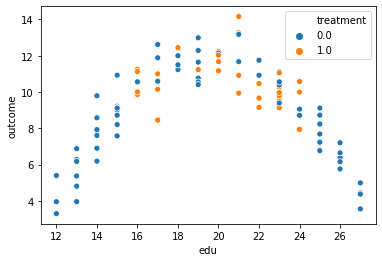

In [7]:
sns.scatterplot(x="edu", y="outcome", hue="treatment", data=df);

In [8]:
### Regression

def power(x):
    return x**2

model_1 = smf.ols(formula = 'outcome ~ edu + treatment', data=df).fit()
model_2 = smf.ols(formula = 'outcome ~ edu + power(edu) + treatment', data=df).fit()

#### case 1

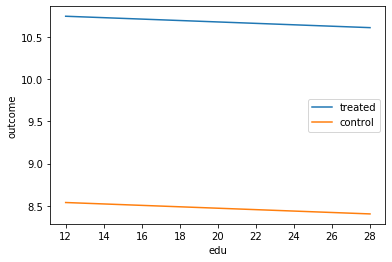

In [9]:
support = np.linspace(12, 28, 1000)
pred_1_treated = model_1.params[0] + model_1.params[1]* support +  model_1.params[2]
pred_1_control = model_1.params[0] + model_1.params[1]* support

plt.plot(support, pred_1_treated, label = 'treated')
plt.plot(support, pred_1_control, label = 'control')
plt.xlabel('edu')
plt.ylabel('outcome')
plt.legend();

#### case 2

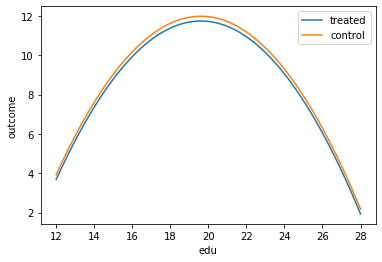

In [10]:
support = np.linspace(12, 28, 1000)
pred_2_treated = model_2.params[0] + model_2.params[1]* support + model_2.params[2]* support**2  + model_2.params[3]
pred_2_control = model_2.params[0] + model_2.params[1]* support + model_2.params[2]* support**2 

plt.plot(support, pred_2_treated, label = 'treated')
plt.plot(support, pred_2_control, label = 'control')
plt.xlabel('edu')
plt.ylabel('outcome')
plt.legend();

### REMARK

- powered termを入れるか入れないかでtreatment effectの推定値が大きく異なることがわかる = model dependence

## 3. Matching

- MatchingとはExact matchingを再現することをゴールとしている
- Exact matchingからのずれの程度をimbalanceという

imbalanceの測り方の一つの方法として、

$$
j(i) = \arg\min_{j|T_j = 1 - T_i}d(X_i, X_j)
$$

and

$$
I(X) = \text{mean}_{i} d(X_i, X_{j(i)})
$$


matchingとは$I(X)$を最小化することobservation subsetを作ることである。

- Mahalanobis Distance Matching
- PS Matching
- Coarsened Exact Matching(大まかな属性で厳密なマッチングをする方法)

## 4. Information Ignored by Propensity Scores

- PS matchingがどのようにしてimbalanceを引き起こすのかを説明する

### 2つの実験デザイン

1.  fully blocked randomized experimental design

- populationから得られたサンプルに対してはじめにpairを作り、そのpair毎にtreatment, controlを割り当てるデザイン
- exact balanced

2. completely randomized experimental design

- populationから得られたサンプルに対して、それぞれのunit of observationにつきコインでtreatment, controlを割り当てるデザイン. 
- PSMはこの状態の再現をゴールとしている
- exact balancedはby chance


PS matchingを実施したとしてもps scoreのバランシングは実現できるが、必ずしも$X_i$のバランシングができるわけではない。

$$
X_i = X_j \Rightarrow \pi_i = \pi_j
$$
$$
\pi_i = \pi_j \nRightarrow X_i = X_j
$$


### REMARKS

- マッチングをするうえでは完全にブロックしたうえでランダムな割り当てをする方法が，ブロックなしの完全なランダム化よりも様々な統計的性質の面で望ましい
- Imai et al. (SS 2009)では，完全にブロックしたうえでランダムな割り当てはブロックなしの完全なランダム化よりも標準誤差が約600%も小さいことが報告されている．
- PSMはあくまでsuboptimal
- PSMよりもマハラノビス距離マッチングやCEMの方が望ましい

## 5. Guidance for Users

- PSMはimbalanced and large sample size dataのときは計算量の観点から使用が正当化されるが、それ以外の場合は慎重になるべき
- PSM実施後のnormalized differenceのチェックは必要不可欠
- PSMを実施するときはマハラノビス距離マッチングやCEMも同時に試すべき
- PSMはpropensity scoreに影響しないcovariateのinformationはignoredされることに留意（heterogeneous treatment effectのとき推定が困難）

### curse of dimensinality and PSM

- PSMはcurse of dimensinalityの解決策とはならない
- covariateが増えれば増えるほどPSMの精度は落ちるとされている (covariateが多いほどmisspecificationの可能性が高まり、biasをもたらしてしまうと考えられる)
